# prepare eva ds

In [5]:
# ! pip install -i https://pypi.tuna.tsinghua.edu.cn/simple matplotlib
import tensorflow as tf
import glob
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import glob
from shutil import copyfile, move

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
    # assert len(physical_devices) > 0, 'Not enough GPU hardware devices available'
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
LABEL_CLASS_LIST = ['OK', 
                    'Overkill',
                    'NG-NoneComp',
                    'NG-OutsidePosition',
                    'NG-UpsideDown',
                    'NG-MoreComp',
                    'NG-InversePolarity',
                    'NG',
                    'Leak',
]
LABEL_TABLE = tf.constant([1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=tf.int64)
ok_lookup = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(LABEL_CLASS_LIST, LABEL_TABLE), -1)
DEGREE_CLASS_LIST = ['0', '180', '270', '90']
DEGREE_LOOKUP = tf.constant(list(range(len(DEGREE_CLASS_LIST))), dtype=tf.int64)
degree_lookup = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(DEGREE_CLASS_LIST, DEGREE_LOOKUP), -1)
def label_to_onehot(label):
    label = ok_lookup.lookup(label)
    onehot_label = tf.one_hot(label, 2, dtype='int64')
    onehot_label = tf.cast(onehot_label, dtype=tf.float32)
    return onehot_label
def degree_to_onehot(degree):
    degree = tf.strings.as_string(
        tf.math.abs(tf.strings.to_number(degree, out_type=tf.dtypes.int64)))
    degree = degree_lookup.lookup(degree)
    onehot_degree = tf.one_hot(degree, len(DEGREE_CLASS_LIST), dtype='int64')
    onehot_degree = tf.cast(onehot_degree, dtype=tf.float32)
    return onehot_degree

In [4]:
def parse_img_96(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 96))
    return img

def new_parse_img_96(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32, expand_animations = False)
    img = tf.image.resize(img, (96, 96), method=tf.image.ResizeMethod.BICUBIC)
    return img

def new_parse_img_96_pad(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize_with_pad(img, 96, 96)
    return img

def parse_img_32_cast(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize_with_pad(img, 32, 32)
    img = tf.cast(img, dtype=tf.float32) / 255.
    return img

def parse_img_32(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32, expand_animations = False)
    img = tf.image.resize(img, (32, 32), method=tf.image.ResizeMethod.BICUBIC)
    return img

# load h5, and evaluate

## all

In [15]:
h5_path = '/p3/trained_h5/2class-cap-all/AddandConcat_trans_r20/b-Xception_lr-3_op-RMSprop_adv-False_ss-0.07354324326618725/ep_007-vl_0.021875-va_0.996438.h5' #by7/23, o.k.:121, leak:504
# h5_path = '/p3/trained_h5/2class-cap-all/AddandConcat_trans_r20/b-DenseNet121_lr-4_op-RMSprop_adv-False_ss-0.027531125394625225/ep_010-vl_0.018639-va_0.996951.h5' #by7/23, o.k.:48, leak:536
# h5_path = '/p3/trained_h5/2class-cap-all/concat_trans_r20/b-VGG16_lr-3_op-adagrad_adv-False_ss-0.07806467279160097/ep_039-vl_0.023681-va_0.997212.h5' #by7/23, o.k.:103, leak:585
# h5_path = '/p3/trained_h5/2class-cap-all/add_trans_r5/b-DenseNet121_lr-3_op-adagrad_adv-False_ss-0.16241258611062806/ep_040-vl_0.002210-va_0.999300.h5' #o.k.:198, leak:92
# h5_path = '/p3/trained_h5/2class-cap-all/color_trans_r10/b-InceptionResNetV2_lr-4_op-adam_adv-False_ss-0.02774057307713597/ep_072-vl_0.004154-va_0.998300.h5' #o.k.:199, leak:49
# h5_path = '/p3/trained_h5/cap-all/cap_all_conv_r15/cc-4_ff-16_ks-5_s-3_mp-False_lr-3_op-adam_adv-True/ep_005-vl_0.002150-va_0.999580.h5' # leak 59
# h5_path = '/p3/trained_h5/cap-all/cap_all_conv_r5/cc-4_ff-16_ks-5_s-2_mp-False_lr-5_op-adagrad_adv-True/ep_028-vl_0.004766-va_0.999280.h5' # leak 77
all_model = tf.keras.models.load_model(h5_path)



In [ ]:
ds = []
for label in LABEL_CLASS_LIST:
    ds.append(tf.data.experimental.SqlDataset(
        'sqlite', '/p3/metadata.db',
        f'''select path, degree, test_label from metadata
        where
            test_label = '{label}' and
            component like '%Cap' and
            extension = 'png'
        ''', (tf.string, tf.string, tf.string)))
dataset = tf.data.experimental.sample_from_datasets(ds)
print(len(list(ds[0])))

In [10]:
dataset = tf.data.experimental.SqlDataset(
    'sqlite', '/tf/robertnb/training/metadata.db',
    f'''select path, degree, label from metadata
        where
            degree >= 0 and
            label != 'OK-InvalidPNG' and 
            component like '%Cap' and
            extension = 'png' and
            label is not NULL''', (tf.string, tf.string, tf.string))

In [16]:
test_dataset = tf.data.experimental.SqlDataset(
    'sqlite', '/tf/robertnb/training/metadata.db',
    f'''
        select path, degree, A4_result from new_metadata 
        where 
            component like '%Cap' and
            extension = 'png' and 
            degree >= 0 
    ''', (tf.string, tf.string, tf.string))

In [17]:
def parse_func(path, degree, label):
    features = {
        'image': new_parse_img_96(path),
        'degree': degree_to_onehot(degree),
        'label': label_to_onehot(label),
    }
    return features, features['label']

In [18]:
old_ds = test_dataset.map(parse_func, tf.data.experimental.AUTOTUNE).batch(1024)
all_model.evaluate(old_ds)

41/41 [==============================] - 9s 231ms/step - loss: 0.0556 - acc: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9966


[0.055647797882556915,
 0.9850112795829773,
 0.9850112795829773,
 0.9850112795829773,
 0.9965831637382507]

In [12]:
! pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --trusted-host pypi.tuna.tsinghua.edu.cn sklearn
! pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --trusted-host pypi.tuna.tsinghua.edu.cn itertools
    
# from sklearn.metrics import classification_report
# import itertools
from sklearn.metrics import confusion_matrix

labels = ['NG', 'OK']
def parse_func(path, degree, label):
    features = {
        'image': new_parse_img_96(path),
        'degree': degree_to_onehot(degree),
        'label': label_to_onehot(label),
    }
    return features, features['label'], path

pre_ds = test_dataset.map(parse_func, tf.data.experimental.AUTOTUNE)
y_test = []
y_predict = []
count = 0
for i, l, p in pre_ds.batch(1024):
    count += 1
    pre = all_model.predict(i)
    for_range = i['image'].shape[0]
    for idx in range(for_range):
        if np.argmax(l[idx].numpy()) == 0:
            y_test.append('NG')
        else:
            y_test.append('OK')
        if np.argmax(pre[idx]) == 0:
            y_predict.append('NG')
        else:
            y_predict.append('OK')

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement sklearn (from versions: none)
ERROR: No matching distribution found for sklearn
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
cm = confusion_matrix(y_test, y_predict, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(im)
# plt.title('Confusion matrix of the all_model')
for i in range(2):
    for j in range(2):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
def parse_func(path, degree, label):
    features = {
        'image': new_parse_img_96(path),
        'degree': degree_to_onehot(degree),
        'label': label_to_onehot(label),
    }
    return features, features['label'], path

pre_ds = test_dataset.map(parse_func, tf.data.experimental.AUTOTUNE)
outcome_dict = {'OK':[], 'NG':[], 'Overkill':[], 'Leak':[]}
for i, l, p in pre_ds.batch(1024):
    pre = all_model.predict(i)
    for_range = i['image'].shape[0]
    for idx in range(for_range):
        fp = p[idx].numpy().decode()
        if np.argmax(l[idx].numpy()) == 0 and np.argmax(pre[idx]) == 0:
            outcome_dict['NG'].append(fp)
        elif np.argmax(l[idx].numpy()) == 1 and np.argmax(pre[idx]) == 1:
            outcome_dict['OK'].append(fp)
        if np.argmax(l[idx].numpy()) == 0 and np.argmax(pre[idx]) == 1:
            outcome_dict['Leak'].append(fp)
        if np.argmax(l[idx].numpy()) == 1 and np.argmax(pre[idx]) == 0:
            outcome_dict['Overkill'].append(fp)

In [20]:
for k in outcome_dict.keys():
    print(k, len(outcome_dict[k]))

OK 38543
NG 2530
Overkill 121
Leak 504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


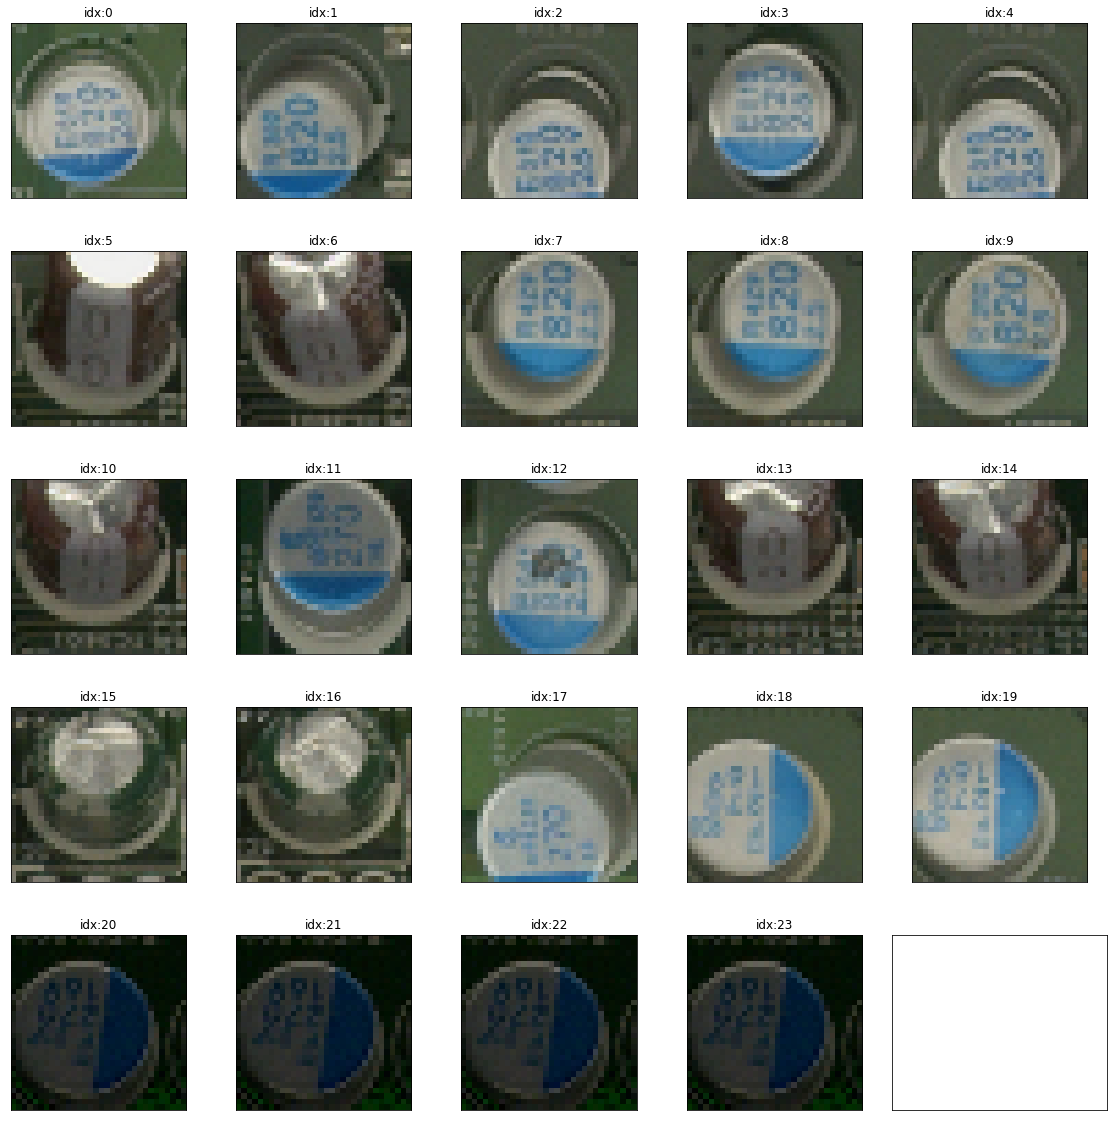

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for idx, (ax, value) in enumerate(zip(axes.flat, outcome_dict['Overkill'][0:25])):
    try:
        ax.imshow(parse_img_32(value))
        ax.set_title(f'idx:{idx}')
    except Exception as e:
        print(e)
plt.show()

In [14]:
conn = sqlite3.connect('/tf/robertnb/training/metadata.db')
c = conn.cursor()

In [16]:
a = outcome_dict['Overkill'][0]
c.execute('select * from new_metadata where path=?',(a,)).fetchall()

[('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA4/0424/OK/CN0TCR49WS20004O010BA00_3550DF010001_PT4702_AluCap_270_820_NA_0.png',
  'CN0TCR49WS20004O010BA00_3550DF010001_PT4702_AluCap_270_820_NA_0.png',
  'CN0TCR49WS20004O010BA00_PT4702',
  'CN0TCR49WS20004O010BA00',
  'PT4702',
  'AluCap',
  '270',
  '820',
  None,
  'NA',
  '0',
  '3550DF010001',
  'png',
  '81',
  '82',
  '20200424',
  None,
  None,
  'OK')]

## m1

In [24]:
# conv
# h5_m1_path = '/p3/trained_h5/cap-model1/alu_m1_r5/5_64_2_1_False_-3_True_False/ep_006-vl_0.024116-va_0.994531.h5' # perform pretty bad
# h5_m1_path = '/p3/trained_h5/cap-model1/alu_m1_r5/5_64_3_3_False_-3_False_False/ep_014-vl_0.001683-va_0.999316.h5'
# h5_m1_path = '/p3/trained_h5/cap-model1/alu_m1_r50/cc3_ff128_ks5_s3_mpTrue_lr-5_opadam_augFalse_advTrue/ep_027-vl_0.003636-va_0.998568.h5'
# transfer
# h5_m1_path = '/p3/trained_h5/cap-model1/alu_m1_r50/b-DenseNet121_lr-5_op-adagrad_aug-False_adv-True_ss-0.05317540872256187/ep_024-vl_0.001970-va_0.999219.h5' #137
# h5_m1_path = '/p3/trained_h5/cap-model1/alu_m1_r50/b-ResNet50V2_lr-5_op-adam_aug-False_adv-False_ss-0.04869529795329122/ep_016-vl_0.002300-va_0.998828.h5' #813
# conv
# h5_m1_path = '/p3/trained_h5/cap-model1/cap_m1_conv_r3/cc-3_ff-32_ks-2_s-2_mp-True_lr-3_op-adagrad_aug-False_adv-True/ep_031-vl_0.005061-va_0.998849.h5' # test.acc 0.99568 # the best: leak 27
# h5_m1_path = '/p3/trained_h5/cap-model1/cap_m1_conv_r11/cc-4_ff-64_ks-3_s-2_mp-False_lr-3_op-adagrad_aug-False_adv-True/ep_014-vl_0.000593-va_0.999812.h5' # test.acc 0.98689
h5_m1_path = '/p3/trained_h5/cap-model1/cap_m1_conv_r11/cc-4_ff-128_ks-2_s-2_mp-False_lr-5_op-RMSprop_aug-False_adv-True/ep_024-vl_0.000891-va_0.999706.h5' # test.acc 0.99971
m1 = tf.keras.models.load_model(h5_m1_path)

In [25]:
labels = [
    'OK', 
    'NG-NoneComp',
    'NG-OutsidePosition',
    'NG-UpsideDown',
    'NG-MoreComp',
]

ds = []
for label in labels:
    ds.append(tf.data.experimental.SqlDataset(
        'sqlite', '/p3/metadata.db',
        f'''select path, test_label from metadata
        where
            test_label = '{label}' and
            component like '%Cap' and
            extension = 'png'
        ''', (tf.string, tf.string)))
dataset = tf.data.experimental.sample_from_datasets(ds)
for p, t in dataset.take(1):
    print(p, t)

tf.Tensor(b'/data/aoi-wzs-p3-dip-prewave-saiap/Phase2-Cap/0904/AluCapacitor/Model-2/OK/270/CN01W26NWS20099302YBA00_PT4701_90_NA_NA.png', shape=(), dtype=string) tf.Tensor(b'OK', shape=(), dtype=string)


In [26]:
m1_index = tf.constant([0, 1, 2, 3, 4], dtype=tf.int64)
m1_lookup = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(labels, m1_index), -1)

In [27]:
def parse_model1(path, label):
    img = parse_img_32(path)
    label = m1_lookup.lookup(label)
    onehot_label = tf.one_hot(label, len(labels), dtype='int64')
    onehot_label = tf.cast(onehot_label, dtype=tf.float32)
    return img, onehot_label

In [28]:
eva_ds = dataset.map(parse_model1, tf.data.experimental.AUTOTUNE).batch(1024)
evaluate = m1.evaluate(eva_ds)
named_results = dict(zip(m1.metrics_names, evaluate))
named_results

    526/Unknown - 40s 75ms/step - loss: 0.0283 - acc: 0.9930 - precision/OK: 0.9999 - precision/NG-NoneComp: 0.9674 - precision/NG-OutsidePosition: 0.3746 - precision/NG-UpsideDown: 0.9143 - precision/NG-MoreComp: 0.1648 - recall/OK: 0.9928 - recall/NG-NoneComp: 0.9943 - recall/NG-OutsidePosition: 0.9519 - recall/NG-UpsideDown: 0.9657 - recall/NG-MoreComp: 0.8721

{'loss': 0.028303315960315368,
 'acc': 0.99297845,
 'precision/OK': 0.9998909,
 'precision/NG-NoneComp': 0.9673756,
 'precision/NG-OutsidePosition': 0.37457278,
 'precision/NG-UpsideDown': 0.9142857,
 'precision/NG-MoreComp': 0.16483517,
 'recall/OK': 0.99280053,
 'recall/NG-NoneComp': 0.99426997,
 'recall/NG-OutsidePosition': 0.95193976,
 'recall/NG-UpsideDown': 0.96566075,
 'recall/NG-MoreComp': 0.872093}

In [29]:
def parse_topre(path, label):
    img = parse_img_32(path)
    label = m1_lookup.lookup(label)
    onehot_label = tf.one_hot(label, len(labels), dtype='int64')
    onehot_label = tf.cast(onehot_label, dtype=tf.float32)
    return img, onehot_label, path
pre_ds = dataset.map(parse_topre, tf.data.experimental.AUTOTUNE)
diff = []
for i, l, p in pre_ds.batch(1024):
    pre = m1.predict(i)
    for_range = i.shape[0]
    for idx in range(for_range):
        if (labels[np.argmax(pre[idx])] == 'OK') and (labels[np.argmax(l[idx].numpy())] != 'OK'):
            ori_label = labels[np.argmax(l[idx].numpy())]
            pre_label = labels[np.argmax(pre[idx])]
            fp = p[idx].numpy().decode()
            _, fn = os.path.split(fp)
            diff.append([ori_label, pre_label, fp, fn])
print(len(diff))

58


In [23]:
for i in range(5):
    path = diff[49+i][2]
    print(path)
#     c.execute(f'update metadata set test_label="NG-NoneComp" where path="{path}"').fetchall()
# con.commit()

/data/aoi-wzs-p3-dip-prewave-saiap/Phase2-Cap/0905/ElecCapacitor/Model-1/NG-NoneComp/CN01W26NWS20099302RJA00_TC3901_90_NA_NA.png
/data/aoi-wzs-p3-dip-prewave-saiap/Phase2-Cap/0905/ElecCapacitor/Model-1/NG-NoneComp/CN00010CWS20099401FSA00_TC3801_90_NA_NA.png
/data/aoi-wzs-p3-dip-prewave-saiap/Phase2-Cap/0908/ElecCapacitor/Model-1/NG-NoneComp/CN06JD9PWS200996001NA00_TC5301_0_NA_NA.png
/data/aoi-wzs-p3-dip-prewave-saiap/Phase2-Cap/0908/ElecCapacitor/Model-1/NG-NoneComp/CN06JD9PWS200996001QA00_TC5301_0_NA_NA.png
/data/aoi-wzs-p3-dip-prewave-saiap/Phase2-Cap/0908/ElecCapacitor/Model-1/NG-NoneComp/CN06JD9PWS200996001OA00_TC5301_0_NA_NA.png


In [26]:
# wrong_index = [84]
# for wi in wrong_index:
#     symbol = (diff[wi][1], diff[wi][2])
#     print(symbol)
#     c.execute(f'update metadata set test_label = ? where path = ?',symbol).fetchall()
#     c.execute(f'update metadata set label = ? where path = ?',symbol).fetchall()
# con.commit()

('OK', '/data/aoi-wzs-p3-dip-prewave-saiap/AIimg2020/1223/ElecCapacitor/EAGLE_355_0DE01_0001-2/OK/CN00010CWS2009CL01HYA00_TC3201_270_NA_NA.png')


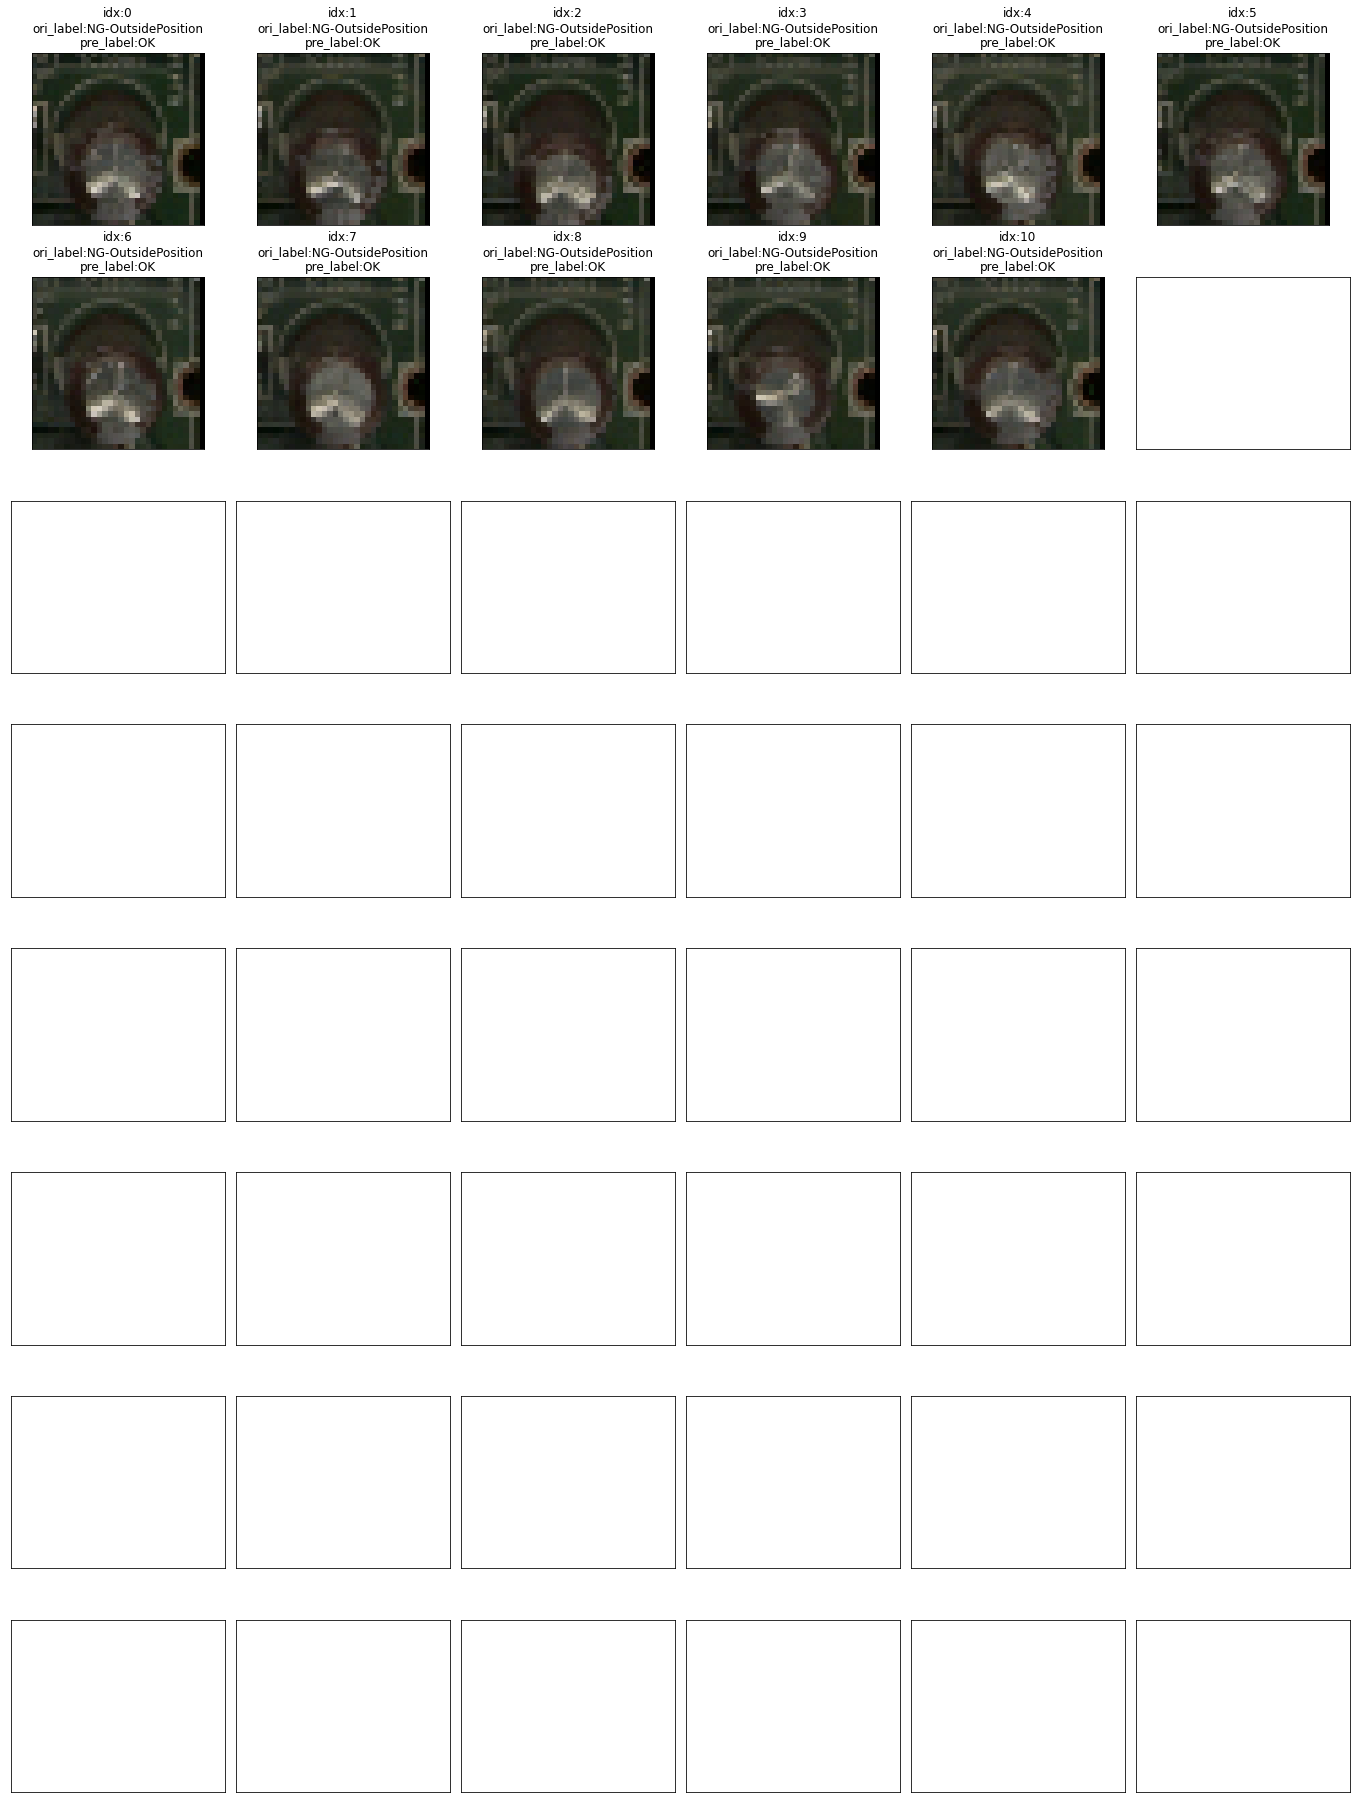

In [15]:
fig, axes = plt.subplots(8, 6, figsize=(24, 32), 
                       subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for idx, (ax, value_list) in enumerate(zip(axes.flat, diff[48:])):
    try:
        ax.imshow(parse_img_32(value_list[2]))
        ax.set_title(f'idx:{idx}\nori_label:{value_list[0]}\npre_label:{value_list[1]}')
    except Exception as e:
        print(e)
plt.show()

## m2

In [14]:
h5_m2_path = '/p3/trained_h5/cap-degree/Conv_random_8/5_64_3_1_True_-4_False_False/ep_013-vl_0.000009-va_1.000000.h5' #1
# h5_path = '/p3/trained_h5/alucap-degree/MobileNetV2/MobileNetV2_0.0_0.0/ep_300-vl_0.003453-va_0.999648.h5' #2
# h5_path = '/p3/trained_h5/alucap-degree/MobileNetV2/MobileNetV2_0.0_1.0/ep_233-vl_0.009611-va_0.999280.h5' #3 failed
# h5_path = '/p3/trained_h5/alucap-degree/MobileNetV2_2/MobileNetV2_0.5_0.3/ep_100-vl_0.002897-va_0.999908.h5' #4
# h5_path = '/p3/trained_h5/alucap-degree/MobileNetV2_2/MobileNetV2_0.5_0.5/ep_100-vl_0.009789-va_0.999843.h5' #5
# h5_path = '/p3/trained_h5/alucap-degree/InceptionV3/MobileNetV2_0.0_0.3/ep_300-vl_0.003386-va_0.999470.h5' #6
# h5_path = '/p3/trained_h5/alucap-degree/ResNet50V2/ResNet50V2_0.3_0.0/ep_209-vl_0.005105-va_0.998994.h5' #7
# h5_path = '/p3/trained_h5/alucap-degree/ResNet50V2/ResNet50V2_0.3_0.0/ep_209-vl_0.005105-va_0.998994.h5' #7
m2 = tf.keras.models.load_model(h5_m2_path)

In [19]:
def parse_path_ok_degree(path, degree):
    img = parse_img_125(path)
    degree = tf.strings.as_string(tf.math.abs(tf.strings.to_number(degree, 
                                                                  out_type=tf.dtypes.int64)))
#     degree = tf.strings.split(input=degree, sep='-')[-1]
    degree = ok_lookup.lookup(degree)
    degree = tf.one_hot(degree, len(class_name), dtype=tf.int64)
    return img, degree

def parse_path_ng_degree(path, degree):
    img = parse_img_125(path)
    degree = ng_lookup.lookup(degree)
    degree = tf.one_hot(degree, len(class_name), dtype=tf.int64)
    return img, degree

In [24]:
eva_ds_mapped = eva_ds.map(parse_path_ok_degree, tf.data.experimental.AUTOTUNE)
if eva_num < batch_size:
    eva_ds_to_eva = eva_ds_mapped.batch(eva_num).prefetch(tf.data.experimental.AUTOTUNE)
else:
    eva_ds_to_eva = eva_ds_mapped.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
results = m2.evaluate(eva_ds_to_eva)
named_results = dict(zip(m2.metrics_names, results))
print(named_results)
print('\naccuracy:', named_results['acc'])

      1/Unknown - 3s 3s/step - loss: 3.5877 - acc: 0.4623 - precision_0: 0.0000e+00 - precision_180: 0.0000e+00 - precision_270: 0.0000e+00 - precision_90: 1.0000 - recall_0: 0.0000e+00 - recall_180: 0.0000e+00 - recall_270: 0.0000e+00 - recall_90: 0.4623{'loss': 3.5876903533935547, 'acc': 0.46226415, 'precision_0': 0.0, 'precision_180': 0.0, 'precision_270': 0.0, 'precision_90': 1.0, 'recall_0': 0.0, 'recall_180': 0.0, 'recall_270': 0.0, 'recall_90': 0.46226415}

accuracy: 0.46226415


# classify

## model 1

In [64]:
alu_to_judge_m1 = '/p3/unlabeled_alu_m1/*/*.png'
elec_to_judge_m1 = '/p3/unlabeled_elec_m1/*/*.png'
to_judge_m1_list = []
for p in glob.glob(alu_to_judge_m1):
    if p.split('/')[-2] != 'NG-InversePolarity':
        to_judge_m1_list.append(p)
for p in glob.glob(elec_to_judge_m1):
    if p.split('/')[-2] != 'NG-InversePolarity':
        to_judge_m1_list.append(p)
len(to_judge_m1_list)

247212

In [47]:
# dest_dir = '/p3/unlabeled_elec_m1/'
# diff_idx = [4, 11, 13, 14, 16, 29, 30, 33]
# diff_idx = [d+144 for d in diff_idx]
# if not os.path.exists(dest_dir):
#     os.makedirs(dest_dir)
# for di in diff_idx:
# #     print(f'{dest_dir}{diff[di][1]}/{diff[di][3]}')
# #     plt.imshow(parse_img_32(diff[di][2]))
#     move(diff[di][2], f'{dest_dir}{diff[di][1]}/{diff[di][3]}')
# #     move(diff[di][2], f'{dest_dir}NG-MoreComp/{diff[di][3]}')

In [30]:
diff[3] #空焊

['NG-OutsidePosition',
 'OK',
 '/p3/unlabeled_alu_m1/NG-OutsidePosition/CN01W26NWS20001A00W0A00_PT4504_AluCap_0_270_NA_0.png',
 'CN01W26NWS20001A00W0A00_PT4504_AluCap_0_270_NA_0.png']

## model 2

In [27]:
ok_path = '/p3/unlabeled_elec_m1/OK/*.png'
# ok_path = '/p3/unlabeled_alu_m1/OK/*.png'
ok_png = glob.glob(ok_path)
len(ok_png)

36923

In [28]:
ok_png_7 = []
ok_png_6 = []
ok_png_5 = []
for p in ok_png:
    d, fn = os.path.split(p)
    if len(fn.split('_')) == 7:
        ok_png_7.append(p)
    elif len(fn.split('_')) == 6:
        ok_png_6.append(p)
    elif len(fn.split('_')) == 5:
        ok_png_5.append(p)
    else:
        print(p)
        break
print(len(ok_png_7))
print(len(ok_png_6))
print(len(ok_png_5))

32900
3339
684
